# Simulating Hess Diagrams with StarFISH

In [1]:
%matplotlib inline
import os
import numpy as np
STARFISH = os.getenv("STARFISH")

'/Users/jsick/code/_starfish/starfish'

In [ ]:
isoc_dirname = "padova_isoc"
lib_dir = "padova_lib"
synth_dir = "wfc3_synth"
fit_dir = "wfc3_fit"

## Download isochrones

The [Padova package](http://github.com/jonathansick/padova) lets us quickly download a set of the Padova group's isochrones from the CMD website. Here we'll download a grid of isochrones to cover a set of WFC3 bands. (*Note: PHAT uses ACS for the optical bands*). Padova is able to export these isochrones into a format that StarFISH understands.

In [2]:
wfc3_bands = ['F275W1', 'F336W', 'F475W', 'F814W', 'F110W', 'F160W']
# z_grid = [0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
#           0.001, 0.0012, 0.0016, 0.002, 0.0025, 0.0031, 0.0039, 0.0049, 0.0061, 0.0077, 0.0096,
#           0.012, 0.015, 0.019, 0.024, 0.03]
# z_grid = [0.015]
z_grid = [0.0096, 0.012, 0.015, 0.019, 0.024, 0.03]

In [3]:
from padova import AgeGridRequest

if not os.path.exists(os.path.join(STARFISH, isoc_dirname):
    for z in z_grid:
        r = AgeGridRequest(z,
                           min_log_age=6.6,
                           max_log_age=10.13,
                           delta_log_age=0.05,
                           phot='wfc3', photsys_version='odfnew')
        for isoc in r.isochrone_set:
            isoc.export_for_starfish(os.path.join(STARFISH, isoc_dirname),
                                     bands=wfc3_bands)

Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache


In [4]:
from astropy.coordinates import Distance
import astropy.units as u

from starfisher import LibraryBuilder

d = Distance(785 * u.kpc)
builder = LibraryBuilder(isoc_dirname, lib_dir,
                         nmag=len(wfc3_bands),
                         dmod=d.distmod.value,
                         iverb=3)
if not os.path.exists(os.path.join(STARFISH, lib_dir)):
    builder.install()

./mklib < wfc3_test/lib.dat


## Generating a synthetic Hess CMD library

In [5]:
from starfisher import Lockfile, Synth, ExtinctionDistribution, MockNullCrowdingTable, ColorPlane

synth_dir = "wfc3_test/synth"
crowd_path = "wfc3_test/crowding.dat"

# Setup an isochrone locking scheme for 12 age bins
# Only use one metallicity
lockfile = Lockfile(builder.read_isofile(), synth_dir)
lockfile.lock_grid(np.linspace(6.4, 10.5, num=12),
                   z_groups=[('0096', '0120'),
                             ('0150', '0190'),
                             ('0240', '0300')])

# No extinction
young_av = ExtinctionDistribution()
old_av = ExtinctionDistribution()
rel_extinction = np.ones(len(wfc3_bands), dtype=float)
for av in (young_av, old_av):
    av.set_uniform(0.)

# No photometric errors
crowd = MockNullCrowdingTable(crowd_path, len(wfc3_bands))

# Define colour planes to synthesize
opt_cmd = ColorPlane((wfc3_bands.index('F475W'), wfc3_bands.index('F814W')),
                     wfc3_bands.index('F814W'),
                     (-1., 3.),
                     (16., 30.),
                     35.,
                     suffix='f475f814',
                     x_label='F475W-F814W',
                     y_label='F814W')

synth = Synth(input_dir, builder, lockfile, crowd,
              rel_extinction, young_extinction=young_av, old_extinction=old_av,
              planes=[opt_cmd])
synth.run_synth(n_cpu=2, include_unlocked=False)
synth.plot_all_hess('synth_hess')

group ('0096', '0120')
z_group ['0096', '0120']
zsel [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141]
group ('0150', '0190')
z_group ['0150', '0190']
zsel [142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159
 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213
 214 215 216 217 218 219 


group ('0096', '0120')
z_group ['0096', '0120']
zsel [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141]
group ('0150', '0190')
z_group ['0150', '0190']
zsel [142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159
 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213
 214 215 216 217 218 219

/Users/jsick/code/_starfish/starfisher/starfisher/plots.py:25: RuntimeWarning: divide by zero encountered in log10
  hess = np.log10(hess)
/Users/jsick/.virtualenvs/starfish/lib/python2.7/site-packages/numpy/ma/core.py:3900: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


./synth < wfc3_test/synth.0.txt
./synth < wfc3_test/synth.1.txt


/Users/jsick/.virtualenvs/starfish/lib/python2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


array([  6.6 ,   6.65,   6.7 ,   6.75,   6.8 ,   6.85,   6.9 ,   6.95,
         7.  ,   7.05,   7.1 ,   7.15,   7.2 ,   7.25,   7.3 ,   7.35,
         7.4 ,   7.45,   7.5 ,   7.55,   7.6 ,   7.65,   7.7 ,   7.75,
         7.8 ,   7.85,   7.9 ,   7.95,   8.  ,   8.05,   8.1 ,   8.15,
         8.2 ,   8.25,   8.3 ,   8.35,   8.4 ,   8.45,   8.5 ,   8.55,
         8.6 ,   8.65,   8.7 ,   8.75,   8.8 ,   8.85,   8.9 ,   8.95,
         9.  ,   9.05,   9.1 ,   9.15,   9.2 ,   9.25,   9.3 ,   9.35,
         9.4 ,   9.45,   9.5 ,   9.55,   9.6 ,   9.65,   9.7 ,   9.75,
         9.8 ,   9.85,   9.9 ,   9.95,  10.  ,  10.05,  10.1 ,   6.6 ,
         6.65,   6.7 ,   6.75,   6.8 ,   6.85,   6.9 ,   6.95,   7.  ,
         7.05,   7.1 ,   7.15,   7.2 ,   7.25,   7.3 ,   7.35,   7.4 ,
         7.45,   7.5 ,   7.55,   7.6 ,   7.65,   7.7 ,   7.75,   7.8 ,
         7.85,   7.9 ,   7.95,   8.  ,   8.05,   8.1 ,   8.15,   8.2 ,
         8.25,   8.3 ,   8.35,   8.4 ,   8.45,   8.5 ,   8.55,   8.6 ,
      

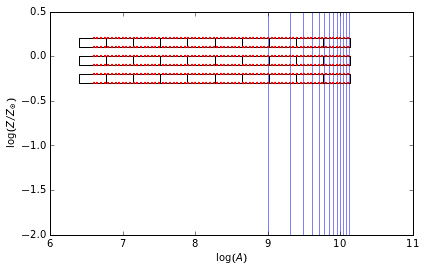

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl

from starfisher.plots import plot_isochrone_logage_logzsol, plot_lock_polygons

fig = plt.figure(figsize=(6.5, 4), dpi=300)
gs = mpl.gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0])

plot_isochrone_logage_logzsol(ax, builder, marker='.', s=20)
plot_lock_polygons(ax, lockfile, facecolor='None')

for gyr in range(1, 14):
    ax.axvline(np.log10(gyr * 1e9), c='b', alpha=0.5, zorder=-1)

ax.set_xlim(6., 11)
ax.set_ylim(-2, 0.5)
ax.set_xlabel(r"$\log(A)$")
ax.set_ylabel(r"$\log(Z/Z_\odot)$")
fig.show()

builder.isoc_logages

In [11]:
for group, multipoly in lockfile.group_polygons.iteritems():
    print "=="
    for verts in multipoly.logage_logzsol_verts:
        print verts

==
[[ 6.4        -0.29648237]
 [ 6.4        -0.19957235]
 [ 6.77272727 -0.19957235]
 [ 6.77272727 -0.29648237]]
==
[[ 6.4        -0.10266234]
 [ 6.4         0.        ]
 [ 6.77272727  0.        ]
 [ 6.77272727 -0.10266234]]
==
[[ 6.4         0.10145764]
 [ 6.4         0.19836765]
 [ 6.77272727  0.19836765]
 [ 6.77272727  0.10145764]]
==
[[ 6.77272727 -0.29648237]
 [ 6.77272727 -0.19957235]
 [ 7.14545455 -0.19957235]
 [ 7.14545455 -0.29648237]]
==
[[ 6.77272727 -0.10266234]
 [ 6.77272727  0.        ]
 [ 7.14545455  0.        ]
 [ 7.14545455 -0.10266234]]
==
[[ 6.77272727  0.10145764]
 [ 6.77272727  0.19836765]
 [ 7.14545455  0.19836765]
 [ 7.14545455  0.10145764]]
==
[[ 7.14545455 -0.29648237]
 [ 7.14545455 -0.19957235]
 [ 7.51818182 -0.19957235]
 [ 7.51818182 -0.29648237]]
==
[[ 7.14545455 -0.10266234]
 [ 7.14545455  0.        ]
 [ 7.51818182  0.        ]
 [ 7.51818182 -0.10266234]]
==
[[ 7.14545455  0.10145764]
 [ 7.14545455  0.19836765]
 [ 7.51818182  0.19836765]
 [ 7.51818182  0.101